**Project Objective:**

In this project, we forecast sales for the next 3 months for 50 different products across 10 different stores using 5 years of store-item sales data. The dataset includes daily sales figures for each store and product. We've applied various techniques to analyze this time series data and predict future demand using machine learning methods.

**Key Highlights:**

- **Model Utilization:** Employed the LightGBM algorithm for sales forecasting. LightGBM is effective in handling large datasets and provides high accuracy.
  
- **Time Series Features:** To enhance model accuracy, we created several key date features:
  - **Exponentially Weighted Mean (EWM):** I computed the exponentially weighted mean on sales data. This method gives more weight to recent data, making the model more sensitive to recent changes and improving prediction accuracy.
  - **Rolling Mean:** I calculated rolling mean to better model trends and seasonality effects.
  - **Lag Features:** I created lag features using past sales data to incorporate historical performance into the model.
  
- **Time Series Analysis:** We processed time series data by considering seasonal patterns, trends, and cyclical effects.

In this project, we achieved high accuracy in sales predictions by applying techniques such as EWM, rolling mean, and lag features to time series data. 

In [49]:
!pip install tabulate


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [83]:
'''
Importing the libraries.
'''
import time
import numpy as np
import pandas as pd
#from matplotlib import pyplot as plt
#import seaborn as sns
import warnings
from tabulate import tabulate
import plotly.graph_objs as go
import plotly
import sys
#import lightgbm as lgb

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')


import ipykernel


#SET GLOBAL FLAG
should_continue_execution = True  # Default to True

In [84]:
'''
This script aims to define custom exception for exception handling purposes. It will be easier to identify errors and issues.
'''
# Debugging and verbose.

def detailed_error_msg(error, error_details: sys):
    '''
    Generate a detailed error message including file name, line number, and error message.
    
    Args:
        error: The original error or exception.
        error_details (sys): System information about the error.
        
    Returns:
        str: A detailed error message.
    '''
    _, _, exception_traceback = error_details.exc_info()
    file_name = exception_traceback.tb_frame.f_code.co_filename
    line_number = exception_traceback.tb_lineno
    detailed_error_message = f'An error occurred in python file [{file_name}] line number [{line_number}] error message [{str(error)}]'
    
    return detailed_error_message


class CustomException(Exception):
    '''
    Custom exception class with detailed error information.
    '''
    def __init__(self, detailed_error_message: str, error_details: sys) -> None:
        '''
        Initialize a DetailedException instance.

        Args:
            detailed_error_message (str): The detailed error message.
            error_details (sys): System information about the error.
        '''
        super().__init__(detailed_error_message)
        self.detailed_error_message = detailed_error_msg(detailed_error_message, error_details=error_details)


    def __str__(self) -> str:
        '''
        Convert the exception to a string representation.
        
        Returns:
            str: The detailed error message.
        '''
        return self.detailed_error_message
    

In [93]:
#print(f"parameter_value for key rb_summary is: {rb_summary} and parameter_value for key rb_detail is: {rb_detail}")
#print(f"parameter_value for key rb_features is: {rb_features}")
#Initialize and Start Execution
from fire_notebook.output.workflowcontext import RestWorkflowContext

parameters_list = sys.argv
print(parameters_list, "parameters_list")

restworkflowcontext = RestWorkflowContext(parameters=parameters_list)
message="20"

rb_detail = restworkflowcontext.getParmeters(parameter_name="rb_detail", default="1")
rb_detail_org = restworkflowcontext.getParmeters(parameter_name="rb_detail", default="1")

rb_features = rb_detail
rb_summary = restworkflowcontext.getParmeters(parameter_name="rb_summary", default="Y")
if rb_detail_org == '3':
    rb_detail = '3'
bt_insights = rb_detail

#print(f"parameter_value for key rb_summary is: {rb_summary} and parameter_value for key rb_detail is: {rb_detail}")

# option = restworkflowcontext.getParmeters(parameter_name="option", default="Profiling")
shape = restworkflowcontext.getParmeters(parameter_name="shape", default='false')
unique_values = restworkflowcontext.getParmeters(parameter_name="unique_values", default='false')
data_types = restworkflowcontext.getParmeters(parameter_name="data_types", default='false')
head = restworkflowcontext.getParmeters(parameter_name="head", default='false')
tail = restworkflowcontext.getParmeters(parameter_name="tail", default='false' )
missing_values = restworkflowcontext.getParmeters(parameter_name="missing_values", default='false')
quantiles = restworkflowcontext.getParmeters(parameter_name="quantiles", default='false')

# Map of parameters to their section names
parameter_map = {
    "shape": shape,
    "unique_values": unique_values,
    "data_types": data_types,
    "head": head,
    "tail": tail,
    "missing_values": missing_values,
    "quantiles": quantiles
}

# Helper function to convert 'true'/'false' strings to boolean
def str_to_bool(value):
    return value.lower() == 'true'

# Initialize an empty list to store sections
sections = []

# Loop over the parameters and append section name if the value is 'true'
for section, parameter_value in parameter_map.items():
    if str_to_bool(parameter_value):  # Convert string 'true'/'false' to boolean
        sections.append(section)

print(f"sections is: {sections}") 
'''
restworkflowcontext.outputProgress(9, title="Progress", progress=message)
# Retrieve individual parameters
shape = restworkflowcontext.getParameters(parameter_name="shape", default="Y")
unique_values = restworkflowcontext.getParameters(parameter_name="unique_values", default="N")
data_types = restworkflowcontext.getParameters(parameter_name="data_types", default="Y")
head = restworkflowcontext.getParameters(parameter_name="head", default="Y")
tail = restworkflowcontext.getParameters(parameter_name="tail", default="Y")
missing_values = restworkflowcontext.getParameters(parameter_name="missing_values", default="N")
quantiles = restworkflowcontext.getParameters(parameter_name="quantiles", default="N")
date_range = restworkflowcontext.getParameters(parameter_name="date_range", default="N")

# Convert individual parameters into a list of section names
sections = []
if shape == "Y":
    sections.append("shape")
if data_types == "Y":
    sections.append("data_types")
if head == "Y":
    sections.append("head")
if tail == "Y":
    sections.append("tail")
if missing_values == "Y":
    sections.append("missing_values")
if quantiles == "Y":
    sections.append("quantiles")
if date_range == "Y":
    sections.append("date_range")
'''

TypeError: __init__() got an unexpected keyword argument 'parameters'

EDA FUNCTIONS

In [32]:
# Define the check_df function
def check_df(dataframe: pd.DataFrame, sections: list = None) -> None:
    if sections is None:
        sections = ['shape', 'unique_values', 'data_types', 'head', 'tail', 'missing_values', 'quantiles']

    if sections is None or 'shape' in sections:
        # Print DataFrame shape
        htmlstr1 = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <h3>Dataset Overview</h3>
            <p>Rows: {dataframe.shape[0]}, Columns: {dataframe.shape[1]}</p>
        </div>
        """
        restworkflowcontext.outHTML(9, title="DataFrame Shape", text=htmlstr1)

    # Display unique values per column if requested
    if sections is None or 'unique_values' in sections:
        unique_values = dataframe.nunique().reset_index()
        unique_values.columns = ['Column', 'Unique Values']
        unique_values_html = unique_values.to_html(index=False, border=0, classes='table table-striped')
    
        # Extract only the <tbody> section from the generated HTML
        tbody_start = unique_values_html.find('<tbody>')
        tbody_end = unique_values_html.find('</tbody>') + len('</tbody>')
        unique_values_tbody = unique_values_html[tbody_start:tbody_end]
    
        unique_values_html_full = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <table class="table table-striped" id="unique_values_table" style="width: 100%; text-align: left;">
                <thead style="text-align: left;">
                    <tr>
                        <th>Column</th>
                        <th>Unique Values</th>
                    </tr>
                </thead>
                {unique_values_tbody}
            </table>
        </div>
        """
        restworkflowcontext.outHTML(10, title="Unique Values Per Column", text=unique_values_html_full)

    # Display data types of columns if requested
    if sections is None or 'data_types' in sections:
        data_types = dataframe.dtypes.reset_index()
        data_types.columns = ['Column', 'Data Type']
        data_types_html = data_types.to_html(index=False, border=0, classes='table table-striped')
        # Extract only the <tbody> section from the generated HTML
        tbody_start = data_types_html.find('<tbody>')
        tbody_end = data_types_html.find('</tbody>') + len('</tbody>')
        data_types_tbody = data_types_html[tbody_start:tbody_end]
    
        data_types_html_full = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <table class="table table-striped" id="data_types_table" style="width: 100%; text-align: left;">
                <thead style="text-align: left;">
                    <tr>
                        <th>Column</th>
                        <th>Data Type</th>
                    </tr>
                </thead>
                {data_types_tbody}
            </table>
        </div>
        """
        restworkflowcontext.outHTML(11, title="Data Types", text=data_types_html_full)

    # Display top rows (head) if requested
    if sections is None or 'head' in sections:
        head_html = dataframe.head().to_html(index=False, border=0, classes='table table-striped')
        # Extract only the <tbody> section from the generated HTML
        tbody_start = head_html.find('<tbody>')
        tbody_end = head_html.find('</tbody>') + len('</tbody>')
        head_tbody = head_html[tbody_start:tbody_end]
    
        head_html_full = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <table class="table table-striped" id="head_table" style="width: 100%; text-align: left;">
                <thead style="text-align: left;">
                    <tr>
                        {"".join(f"<th>{col}</th>" for col in dataframe.columns)}
                    </tr>
                </thead>
                {head_tbody}
            </table>
        </div>
        """
        restworkflowcontext.outHTML(12, title="Top Rows (Head)", text=head_html_full)

    # Display bottom rows (tail) if requested
    if sections is None or 'tail' in sections:
        tail_html = dataframe.tail().to_html(index=False, border=0, classes='table table-striped')
    
        # Extract only the <tbody> section from the generated HTML
        tbody_start = tail_html.find('<tbody>')
        tbody_end = tail_html.find('</tbody>') + len('</tbody>')
        tail_tbody = tail_html[tbody_start:tbody_end]
    
        tail_html_full = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <table class="table table-striped" id="tail_table" style="width: 100%; text-align: left;">
                <thead style="text-align: left;">
                    <tr>
                        {"".join(f"<th>{col}</th>" for col in dataframe.columns)}
                    </tr>
                </thead>
                {tail_tbody}
            </table>
        </div>
        """
        restworkflowcontext.outHTML(13, title="Bottom Rows (Tail)", text=tail_html_full)    

    # Display missing values per column if requested
    if sections is None or 'missing_values' in sections:
        missing_values = dataframe.isnull().sum().reset_index()
        missing_values.columns = ['Column', 'Missing Values']
        missing_values_html = missing_values.to_html(index=False, border=0, classes='table table-striped')
    
    # Extract only the <tbody> section from the generated HTML
        tbody_start = missing_values_html.find('<tbody>')
        tbody_end = missing_values_html.find('</tbody>') + len('</tbody>')
        missing_values_tbody = missing_values_html[tbody_start:tbody_end]
    
        missing_values_html_full = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <table class="table table-striped" id="missing_values_table" style="width: 100%; text-align: left;">
                <thead style="text-align: left;">
                    <tr>
                        <th>Column</th>
                        <th>Missing Values</th>
                    </tr>
                </thead>
                {missing_values_tbody}
            </table>
        </div>
        """
        restworkflowcontext.outHTML(14, title="Missing Values Per Column", text=missing_values_html_full)

    # Print date range if 'date' column exists
    if 'date' in dataframe.columns and pd.api.types.is_datetime64_any_dtype(dataframe['date']):
        date_range_html = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <h3>Date Range</h3>
            <p>Start Date: {dataframe['date'].min()}</p>
            <p>End Date: {dataframe['date'].max()}</p>
        </div>
        """
        restworkflowcontext.outHTML(15, title="Date Range", text=date_range_html)

    # Print quantile statistics
    if sections is None or 'quantiles' in sections:
        quantiles = dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T.reset_index()
        quantiles_html = quantiles.to_html(index=False, border=0, classes='table table-striped')
    
        # Extract only the <tbody> section from the generated HTML
        tbody_start = quantiles_html.find('<tbody>')
        tbody_end = quantiles_html.find('</tbody>') + len('</tbody>')
        quantiles_tbody = quantiles_html[tbody_start:tbody_end]
    
        quantiles_html_full = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <table class="table table-striped" id="quantiles_table" style="width: 100%; text-align: left;">
                <thead style="text-align: left;">
                    <tr>
                        {"".join(f"<th>{col}</th>" for col in quantiles.columns)}
                    </tr>
                </thead>
                {quantiles_tbody}
            </table>
        </div>
        """
        restworkflowcontext.outHTML(16, title="Quantiles", text=quantiles_html_full)


# target summary with cat cols
# Function to see the average sales for each store and the average sales for each item.
#Example Business Questions that can be answered:
    #Which store has the highest average sales value?
    #Which item has the lowest average sales value?

def target_summary_with_cat(dataframe, target, categorical_cols):
    for col in categorical_cols:
        summary_df = dataframe.groupby(col)[target].mean().reset_index()
        summary_df.columns = [col, "TARGET_MEAN"]

        # Convert DataFrame to HTML
        summary_html = summary_df.to_html(index=False, border=0, classes='table table-striped')

        # Extract <tbody> section (optional, for styling)
        tbody_start = summary_html.find('<tbody>')
        tbody_end = summary_html.find('</tbody>') + len('</tbody>')
        summary_tbody = summary_html[tbody_start:tbody_end]

        # Wrap HTML in a div for styling (optional)
        summary_html_full = f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;">
            <table class="table table-striped" id="summary_table" style="width: 100%; text-align: left;">
                <thead>
                    <tr>
                        <th>{col}</th>
                        <th>TARGET_MEAN</th>
                    </tr>
                </thead>
                {summary_tbody}
            </table>
        </div>
        """
        restworkflowcontext.outHTML(16, title="Detailed Report", text=summary_html_full)

        print(summary_df, end="\n\n\n")

        # Create histogram
        plt.figure(figsize=(15, 6))
        plt.bar(summary_df[col].astype(str), summary_df["TARGET_MEAN"], color='skyblue')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.title(f"{target} mean for {col}")
        plt.xticks(rotation=45)
        plt.show()
        #fig = plotly.offline.plot([go.Bar(x=summary_df[col], y=summary_df["TARGET_MEAN"])], output_type='div', include_plotlyjs=False)
        #example_plotly = f'{fig}'
        #restworkflowcontext.outPlotly(9, title="MEAN OF", text=example_plotly )
        #fig = go.Figure(data=[go.Bar(x=summary_df[col], y=summary_df["TARGET_MEAN"])])
        fig = go.Figure(data=[go.Bar(x=summary_df[col], y=summary_df["TARGET_MEAN"], marker_color='skyblue')])
        fig.update_layout(
            #title=f"{target} mean for {col}",
            xaxis_title=col,
            yaxis_title=target
        )

        # Display the chart (replace with your output method)
        fig_html = plotly.offline.plot(fig, output_type='div', include_plotlyjs=False)
        restworkflowcontext.outPlotly(9, title= f"{target.upper()} MEAN FOR {col.upper()}", text=fig_html )


In [33]:
train = pd.read_csv('demand-train.csv', parse_dates=['date'])
#test = pd.read_csv('/dbfs/FileStore/Demand-Forecasting/Input/test.csv', parse_dates=['date'])
#sample_sub = pd.read_csv('/dbfs/FileStore/Demand-Forecasting/Input/demand_forecasting.csv')

#df = pd.concat([train, test], sort=False)
df = train

Retrieved rb_summary: Y and rb_detail: 1
Check the Input type.
 And Input is string type.
++++++
Sending Message: {'text': '        <div style=@@border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;@@>            <h3>Dataset Overview</h3>            <p>Rows: 913000, Columns: 4</p>        </div>        ', 'id': 9, 'name': 'DataFrame Shape', 'title': 'DataFrame Shape', 'type': 'html', 'resultType': 3, 'visibility': 'EXPANDED', 'time': 'Sep 18, 2024 09:08:29 AM'}
Error : HTTPConnectionPool(host='localhost', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc6ec64e640>: Failed to establish a new connection: [Errno 111] Connection refused'))
++++++
Check the Input type.
 And Input is string type.
++++++
Sending Message: {'text': '        <div style=@@border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;@@>            <table class=@@table table-striped@@ 

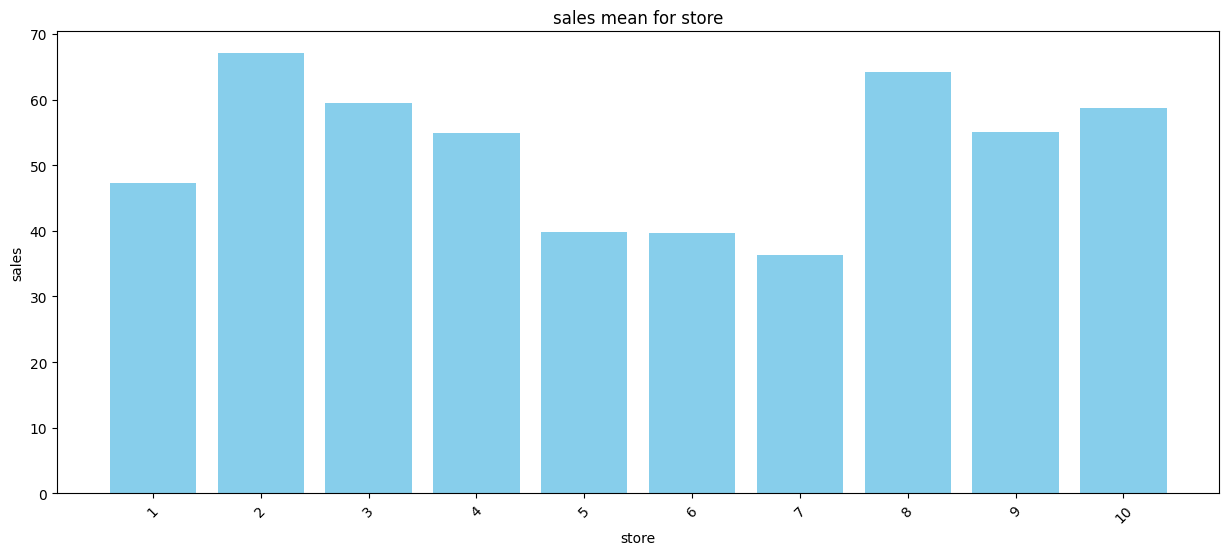

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot(                        @@dbeffeb4-dd64-4333-8e1a-f18e065fa1e8@@,                        [{@@marker@@:{@@color@@:@@skyblue@@},@@x@@:[1,2,3,4,5,6,7,8,9,10],@@y@@:[47.268378970427165,67.03316538882804,59.530602409638554,54.90294633077766,39.77016429353779,39.733515881708655,36.363734939759034,64.14204819277109,55.049025191675796,58.70928806133625],@@type@@:@@bar@@}],                        {@@template@@:{@@data@@:{@@barpolar@@:[{@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@barpolar@@}],@@bar@@:[{@@error_x@@:{@@color@@:@@#2a3f5f@@},@@error_y@@:{@@color@@:@@#2a3f5f@@},@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@bar@@}],@@carpet@@:[{@@aaxis@@:{@@endlinecolor@@:@@#2a3f5f@@,@@gridcolor@@:@@white@@,@@

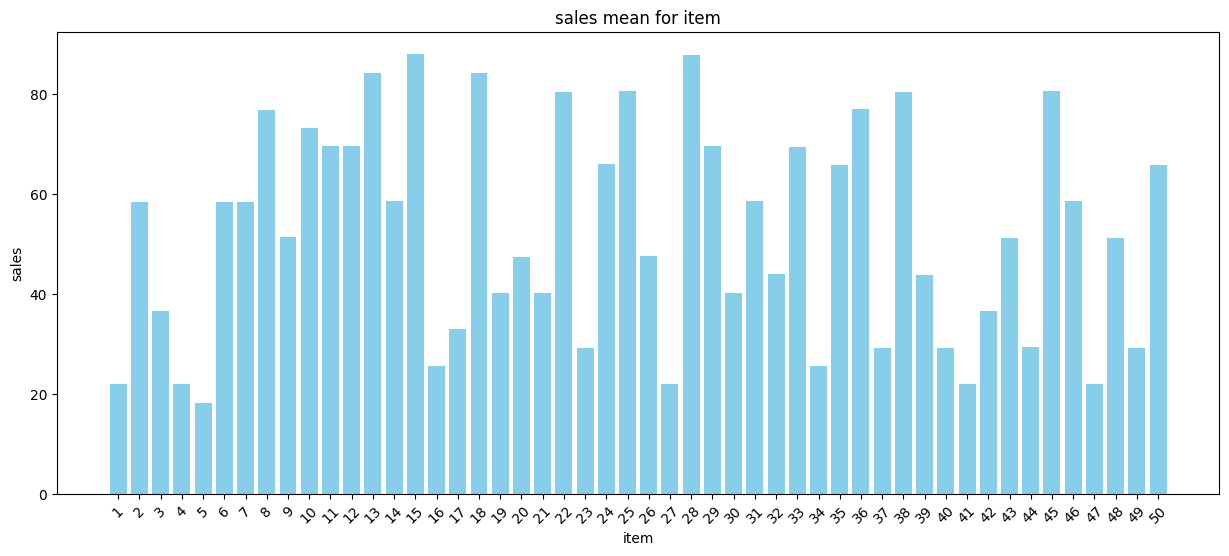

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot(                        @@d59d0be2-cdfc-424d-bf4c-5bf6bf0c3421@@,                        [{@@marker@@:{@@color@@:@@skyblue@@},@@x@@:[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50],@@y@@:[21.981599123767797,58.57415115005477,36.64222343921139,22.01024096385542,18.35870755750274,58.50388828039431,58.53105147864184,76.9500547645126,51.38986856516977,73.22743702081051,69.65635268346112,69.63493975903614,84.31659364731654,58.68187294633078,88.03077765607885,25.656078860898138,32.99485213581599,84.27579408543264,40.35553121577218,47.51593647316539,40.3170865279299,80.50224534501643,29.297864184008763,66.04463307776561,80.68641840087624,47.64408543263965,22.04972617743702,87.88132530120482,69.61883899233297,40.33702081051479,58.64430449069003,43.98176341730559,69.56095290251916,25.73576122672

In [34]:
def run_analysis(dataframe, sections):
    global should_continue_execution 
    # Retrieve widget values
    #rb_summary = dbutils.widgets.get("rb_summary")
    #rb_detail = dbutils.widgets.get("rb_detail")
    rb_summary = 'Y'
    rb_detail = 1
    
    # Ensure rb_detail is a string for consistent comparison
    if isinstance(rb_detail, int):
        rb_detail = str(rb_detail)

    # Debug print statement
    print(f"Retrieved rb_summary: {rb_summary} and rb_detail: {rb_detail}")

    # Check if both rb_summary and rb_detail are set to 'Y' and '1' respectively
    if rb_summary == 'Y' and rb_detail == '1':
        check_df(dataframe, sections=['shape', 'unique_values', 'data_types', 'head', 'tail', 'missing_values', 'quantiles'])
        target_summary_with_cat(
            dataframe,
            options['target'],
            options['categorical_col']
        )
        should_continue_execution = False
        return  # Stop further execution

    # Check if only rb_summary is set to 'Y'
    if rb_summary == 'Y':
        check_df(dataframe, sections=['shape', 'unique_values', 'data_types', 'head', 'tail', 'missing_values', 'quantiles'])
        #check_df(dataframe, sections=['shape', 'unique_values']
        should_continue_execution = False
        return  # Stop further execution

    # Check if only rb_detail is set to '1'
    if rb_detail == '1':
        target_summary_with_cat(
            dataframe,
            options['target'],
            options['categorical_col']
        )
        should_continue_execution = False
        return  # Stop further execution

    if rb_detail == '2' and rb_summary == 'N':
        should_continue_execution = True  # Ensure execution continues to the next cell
        print("Skipping this cell based on rb_detail and rb_summary values.")
        return  # Exit the function, skipping the rest of the cell



# Example usage of the function
dataframe = df
options = {
    'target': 'sales',           # Replace 'sales' with the actual target column name in your DataFrame
    'categorical_col': ['store', 'item']  # Replace 'store' and 'item' with the actual categorical column names in your DataFrame
}

# Call the run_analysis function with the desired sections
#run_analysis(dataframe, sections=['shape', 'unique_values', 'data_types', 'head', 'tail', 'missing_values', 'quantiles'])

run_analysis(dataframe, sections=['shape', 'unique_values'])

if not should_continue_execution:
    message="100"
    restworkflowcontext.outputProgress(9, title="Progress", progress=message)

    message = "Job Execution Completed."
    restworkflowcontext.outSuccess(9, title="Success", text=message)    
    #!stop
    
else:
    print(f"First  values: rb_detail={rb_detail}, rb_summary={rb_summary}")

Retrieved rb_summary: Y and rb_detail: 1
Check the Input type.
 And Input is string type.
++++++
Sending Message: {'text': '    <div style=@@border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;@@>        <h3>Dataset Overview</h3>        <p>Rows: 913000, Columns: 4</p>    </div>    ', 'id': 9, 'name': 'DataFrame Shape', 'title': 'DataFrame Shape', 'type': 'html', 'resultType': 3, 'visibility': 'EXPANDED', 'time': 'Sep 18, 2024 08:41:31 AM'}
Error : HTTPConnectionPool(host='localhost', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc6ec500e20>: Failed to establish a new connection: [Errno 111] Connection refused'))
++++++
Check the Input type.
 And Input is string type.
++++++
Sending Message: {'text': '    <div style=@@border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; background-color: #f9f9f9;@@>        <table class=@@table table-striped@@ id=@@unique_values_table@@ s

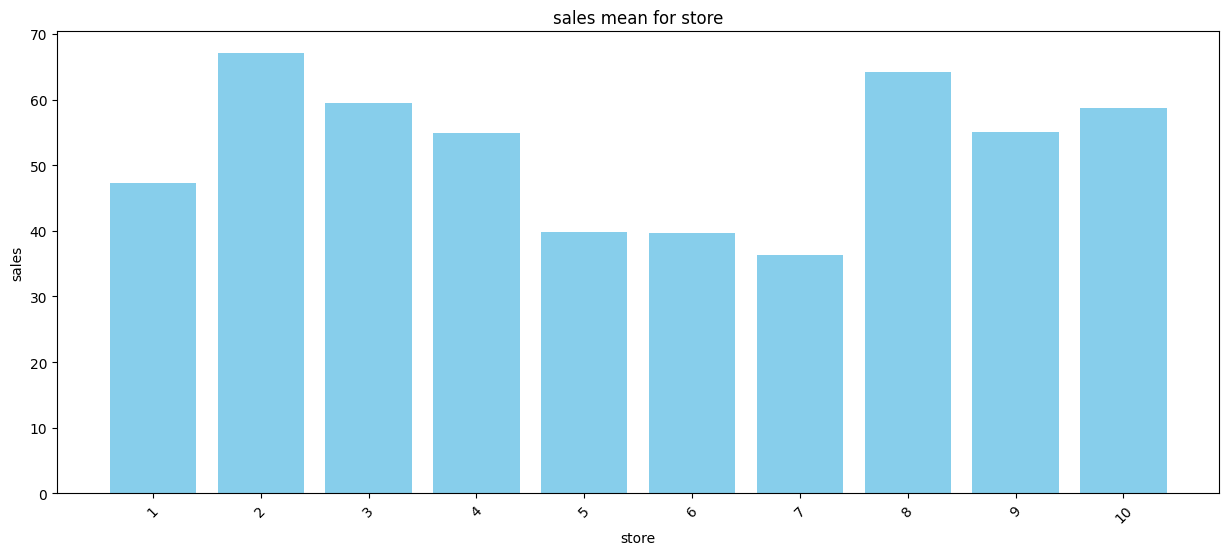

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot(                        @@55fff943-81d9-49d8-b647-64736fb1ba4d@@,                        [{@@marker@@:{@@color@@:@@skyblue@@},@@x@@:[1,2,3,4,5,6,7,8,9,10],@@y@@:[47.268378970427165,67.03316538882804,59.530602409638554,54.90294633077766,39.77016429353779,39.733515881708655,36.363734939759034,64.14204819277109,55.049025191675796,58.70928806133625],@@type@@:@@bar@@}],                        {@@template@@:{@@data@@:{@@barpolar@@:[{@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@barpolar@@}],@@bar@@:[{@@error_x@@:{@@color@@:@@#2a3f5f@@},@@error_y@@:{@@color@@:@@#2a3f5f@@},@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@bar@@}],@@carpet@@:[{@@aaxis@@:{@@endlinecolor@@:@@#2a3f5f@@,@@gridcolor@@:@@white@@,@@

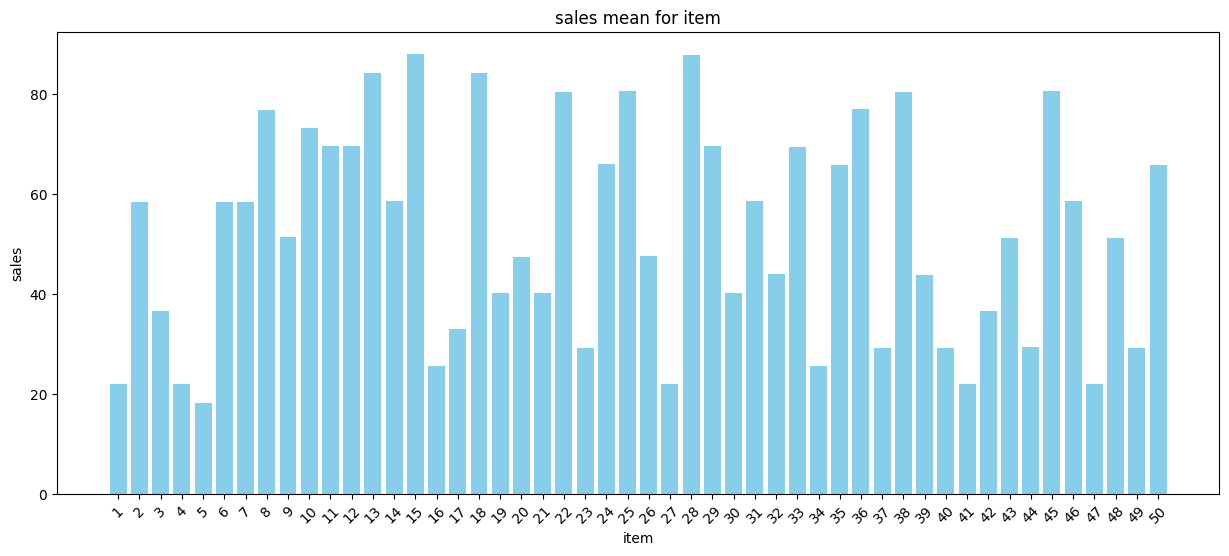

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot(                        @@fefb1b7d-94df-4f4d-9a05-11a3ddf086f3@@,                        [{@@marker@@:{@@color@@:@@skyblue@@},@@x@@:[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50],@@y@@:[21.981599123767797,58.57415115005477,36.64222343921139,22.01024096385542,18.35870755750274,58.50388828039431,58.53105147864184,76.9500547645126,51.38986856516977,73.22743702081051,69.65635268346112,69.63493975903614,84.31659364731654,58.68187294633078,88.03077765607885,25.656078860898138,32.99485213581599,84.27579408543264,40.35553121577218,47.51593647316539,40.3170865279299,80.50224534501643,29.297864184008763,66.04463307776561,80.68641840087624,47.64408543263965,22.04972617743702,87.88132530120482,69.61883899233297,40.33702081051479,58.64430449069003,43.98176341730559,69.56095290251916,25.73576122672

In [26]:
def run_analysis2(dataframe, options):
    global should_continue_execution 
    # Retrieve widget values
    #rb_summary = dbutils.widgets.get("rb_summary")
    #rb_detail = dbutils.widgets.get("rb_detail")
    rb_summary = 'Y'
    rb_detail = 1
    
    # Ensure rb_detail is a string for consistent comparison
    if isinstance(rb_detail, int):
        rb_detail = str(rb_detail)

    # Debug print statement
    print(f"Retrieved rb_summary: {rb_summary} and rb_detail: {rb_detail}")



    # Check if both rb_summary and rb_detail are set to 'Y' and '1' respectively
    if rb_summary == 'Y' and rb_detail == '1':
        check_df(dataframe)
        target_summary_with_cat(
            dataframe,
            options['target'],
            options['categorical_col']
        )
        should_continue_execution = False
        return  # Stop further execution

    # Check if only rb_summary is set to 'Y'
    if rb_summary == 'Y':
        check_df(dataframe)
        should_continue_execution = False
        return  # Stop further execution

    # Check if only rb_detail is set to '1'
    if rb_detail == '1':
        target_summary_with_cat(
            dataframe,
            options['target'],
            options['categorical_col']
        )
        should_continue_execution = False
        return  # Stop further execution

    if rb_detail == '2' and rb_summary == 'N':
        should_continue_execution = True  # Ensure execution continues to the next cell
        print("Skipping this cell based on rb_detail and rb_summary values.")
        return  # Exit the function, skipping the rest of the cell



# Example usage of the function
dataframe = df
options = {
    'target': 'sales',           # Replace 'sales' with the actual target column name in your DataFrame
    'categorical_col': ['store', 'item']  # Replace 'store' and 'item' with the actual categorical column names in your DataFrame
}

# Call the run_analysis function
run_analysis(dataframe, options)

if not should_continue_execution:
    message="100"
    restworkflowcontext.outputProgress(9, title="Progress", progress=message)

    message = "Job Execution Completed."
    restworkflowcontext.outSuccess(9, title="Success", text=message)    
    #!stop
    
else:
    print(f"First  values: rb_detail={rb_detail}, rb_summary={rb_summary}") 



In [ ]:
# Function to provide a more comprehensive understanding of sales performance.
#Total Sales: See which store-item combinations generate the highest overall revenue.
#Average Sales: Understand typical sales performance for each combination.
#Median Sales: Get a sense of the "typical" sale amount, less influenced by outliers.

#Example Business Questions that can be answered:
  #Which store-item pair has the highest total sales value?
  #Which store-item pair has the highest average sales value?
  #Which store-item pair has the most consistent sales values (i.e., lowest standard deviation)?



def generate_detailed_sales_summary(df):
    summary_df = df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

    # Find the store-item pair with the highest total sales value
    highest_total_sales = summary_df['sales']['sum'].nlargest(1)

    # Find the store-item pair with the highest average sales value
    highest_average_sales = summary_df['sales']['mean'].nlargest(1)

    # Find the store-item pair with the most consistent sales values (i.e., lowest standard deviation)
    most_consistent_sales = summary_df['sales']['std'].nsmallest(1)


    print(f"Aggregates: highest_total_sales={highest_total_sales}, highest_average_sales={highest_average_sales}") 

    # Create HTML string with styled output
    html_output = f"""
    <div style="font-family: Arial, sans-serif; background-color: #f5f5f5; padding: 20px; border-radius: 5px;">
        <h2 style="color: #333; font-size: 24px; margin-bottom: 20px;">Sales Analysis For Store-Item pair</h2>
        <table style="width: 100%; border-collapse: collapse;">
            <thead>
                <tr style="background-color: #0c9a86; color: white;">
                    <th style="padding: 10px; text-align: left;">Metric</th>
                    <th style="padding: 10px; text-align: left;">Store</th>
                    <th style="padding: 10px; text-align: left;">Item</th>
                    <th style="padding: 10px; text-align: left;">Value</th>
                </tr>
            </thead>
            <tbody>
                <tr style="background-color: #f2f2f2;">
                    <td style="padding: 8px; text-align: left;">Highest Total Sales</td>
                    {''.join([f'<td style="padding: 8px; text-align: left;">{int(v) if i in [1, 2] else v}</td>' for i, v in enumerate(highest_total_sales.reset_index().iloc[0].values)])}
                </tr>
                <tr>
                    <td style="padding: 8px; text-align: left;">Highest Average Sales</td>
                    {''.join([f'<td style="padding: 8px; text-align: left;">{int(v) if i in [1, 2] else v}</td>' for i, v in enumerate(highest_average_sales.reset_index().iloc[0].values)])}
                </tr>
                <tr style="background-color: #f2f2f2;">
                    <td style="padding: 8px; text-align: left;">Most Consistent Sales</td>
                    {''.join([f'<td style="padding: 8px; text-align: left;">{int(v) if i in [1, 2] else v}</td>' for i, v in enumerate(most_consistent_sales.reset_index().iloc[0].values)])}
                </tr>
            </tbody>
        </table>
    </div>
    """
    #print(html_output)
    restworkflowcontext.outHTML(16, title="Inital Insights", text=html_output)

    should_continue_execution = False
    return  # Stop further execution

if rb_detail  == '2':
    # Call the function
    generate_detailed_sales_summary(df)
    should_continue_execution = False
    message="100"
    restworkflowcontext.outputProgress(9, title="Progress", progress=message)
    message = "Job Execution Completed."
    restworkflowcontext.outSuccess(9, title="Success", text=message)    
    dbutils.notebook.exit("Execution stopped by generate_detailed_sales_summary function.")    
  
elif rb_detail == '3' and rb_summary == 'N':
    should_continue_execution = True  # Ensure execution continues to the next cell
    print("Skipping this cell based on rb_detail and rb_summary values.")
  
else:
    # Exit the notebook if bt_insights is not 'Y'
    message="100"
    restworkflowcontext.outputProgress(9, title="Progress", progress=message)
    message = "Job Execution Completed."
    restworkflowcontext.outSuccess(9, title="Success", text=message)    
    dbutils.notebook.exit("Execution stopped by generate_detailed_sales_summary function.")
    